<a href="https://colab.research.google.com/github/Dominika26/classification_tutorials_public/blob/main/TensorFlow_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Las decyzyjny TensorFlow**

In [1]:
pip install tensorflow_decision_forests

     |████████████████████████████████| 13.4 MB 3.0 MB/s 
     |████████████████████████████████| 462 kB 49.3 MB/s 


In [2]:
pip install wurlitzer

In [3]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [5]:
@register_line_magic 
def set_cell_height(size):
  display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))
  

In [6]:
# Check the version of tensorflow decision forests
print("Found TensorFlow Forests v" + tfdf.__version__)

Found TensorFlow Forests v0.2.4


**Trening losowego modelu lasu**


Załadowanie zestawu danych i konwersja do tf.Dataset

In [7]:
# Download the dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("/tmp/penguins.csv")

# Display the first 3 examples.
dataset_df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


Mamy tutaj dane numeryczne, kategoryczne (island) i brakujące funkcje, TF-DF obsługuje wszystkie te typy funkcji natywnie więc nie ma potrzeby przeprowadzania normalizacji czy hot coding jka to było w przypadku adoption example.

Etykieta species jest przechowywana jako string, należy ją przekształcić na liczby całkowite.

In [8]:
label = "species"

classes = dataset_df[label].unique().tolist()
print(f"Label classes: {classes}")
dataset_df[label] = dataset_df[label].map(classes.index)


Label classes: ['Adelie', 'Gentoo', 'Chinstrap']


Podział danych na zbiór testowy i treningowy 

In [9]:
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

245 examples in training, 99 examples for testing.


Konwersja pd.DataFrame do tf.data.Dataset

Czyli z tego co rozumiem, staramy się przwidzieć gatunek 

In [10]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


**Trenowanie modelu**


In [11]:
%set_cell_height 300

#Specify the model 
model_1 = tfdf.keras.RandomForestModel()

#Evaluation metrics
model_1.compile(
    metrics=["accuracy"]
)

#Train the model 
with sys_pipes():
  model_1.fit(x=train_ds)
  

<IPython.core.display.Javascript object>

Use /tmp/tmpe7olmov3 as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:05.755265
Training model
Model trained in 0:00:00.062724
Compiling model


[INFO kernel.cc:1153] Loading model from path
[

1/1 [==============================] - 6s 6s/step


INFO abstract_model.cc:1063] Engine "RandomForestGeneric" built
[INFO kernel.cc:1001] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


**Ocena modelu**

In [12]:
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value}4f")

1/1 [==============================] - 1s 808ms/step - loss: 0.0000e+00 - accuracy: 0.9697

loss: 0.04f
accuracy: 0.96969699859619144f


**Przygotuj model do obsługi TensorFlow**


In [13]:
model_1.save("/tmp/my_saved_model1")

INFO:tensorflow:Assets written to: /tmp/my_saved_model1/assets


INFO:tensorflow:Assets written to: /tmp/my_saved_model1/assets


***Wykreśl model***

In [14]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

**Struktura modelu i znaczenie funkcji**
- Typ: algorytm uczenia używany do szkolenia modelu ( Random Forest w naszym przypadku).
- Zadanie: Problem rozwiązany przez model ( Classification w naszym przypadku).
- Wejście Funkcje: Wejście cechy modelu.
- Zmienna Znaczenie: Różne środki znaczenia poszczególnych funkcji dla modelu.
- Out-of-bag oceny: Ocena out-of-bag modelu. Jest to tania i wydajna alternatywa dla walidacji krzyżowej.
- Liczba drzew, węzły {} i innych danych: Dane statystyczne dotyczące struktury lasów decyzje.

In [15]:
%set_cell_height 300
model_1.summary()

<IPython.core.display.Javascript object>

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	bill_depth_mm
	bill_length_mm
	body_mass_g
	flipper_length_mm
	island
	sex
	year

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.           "__LABEL"  2.951803 ################
    2.               "sex"  2.940447 ###############
    3.              "year"  2.935885 ###############
    4.       "body_mass_g"  2.452069 ###########
    5.            "island"  2.183208 #########
    6.     "bill_depth_mm"  2.163892 ########
    7.    "bill_length_mm"  1.219276 
    8. "flipper_length_mm"  1.170158 

Variable Importance: NUM_AS_ROOT:
    1. "flipper_length_mm" 153.000000 ################
    2.    "bill_length_mm" 92.00

In [16]:
model_1.make_inspector().features()

["bill_depth_mm" (1; #0),
 "bill_length_mm" (1; #1),
 "body_mass_g" (1; #2),
 "flipper_length_mm" (1; #3),
 "island" (4; #4),
 "sex" (4; #5),
 "year" (1; #6)]

In [17]:
model_1.make_inspector().variable_importances()

{'MEAN_MIN_DEPTH': [("__LABEL" (4; #7), 2.9518032893032857),
  ("sex" (4; #5), 2.9404474691974656),
  ("year" (1; #6), 2.9358852998852973),
  ("body_mass_g" (1; #2), 2.4520688385688363),
  ("island" (4; #4), 2.1832082269582296),
  ("bill_depth_mm" (1; #0), 2.1638924963924984),
  ("bill_length_mm" (1; #1), 1.2192762052762067),
  ("flipper_length_mm" (1; #3), 1.170158175158175)],
 'NUM_AS_ROOT': [("flipper_length_mm" (1; #3), 153.0),
  ("bill_length_mm" (1; #1), 92.0),
  ("bill_depth_mm" (1; #0), 38.0),
  ("body_mass_g" (1; #2), 10.0),
  ("island" (4; #4), 7.0)],
 'NUM_NODES': [("bill_length_mm" (1; #1), 537.0),
  ("flipper_length_mm" (1; #3), 352.0),
  ("bill_depth_mm" (1; #0), 325.0),
  ("island" (4; #4), 270.0),
  ("body_mass_g" (1; #2), 239.0),
  ("year" (1; #6), 14.0),
  ("sex" (4; #5), 10.0)],
 'SUM_SCORE': [("bill_length_mm" (1; #1), 27431.66457260959),
  ("flipper_length_mm" (1; #3), 24267.03814629838),
  ("island" (4; #4), 10214.331824848428),
  ("bill_depth_mm" (1; #0), 8780.05

**Samoocena modelu**

In [18]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=245, accuracy=0.963265306122449, loss=0.08065945486899237, rmse=None, ndcg=None, aucs=None)

**Tworzenie logów treningowych**

Pokazują jakość modelu zgodnie z liczbą drzew w modelu. 

In [19]:
%set_cell_height 150
model_1.make_inspector().training_logs()

<IPython.core.display.Javascript object>

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=92, accuracy=0.9130434782608695, loss=3.1342305722443955, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=244, accuracy=0.9631147540983607, loss=0.359223054630346, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=245, accuracy=0.9591836734693877, loss=0.22980911111345095, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=245, accuracy=0.9673469387755103, loss=0.08438260880660038, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=245, accuracy=0.963265306122449, loss=0.08575351507383949, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=245, accuracy=0.963265306122449, loss=0.09064132872284675, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=61, evaluation=Evaluation(num_examples=245, accuracy=0.96734693

Wykres

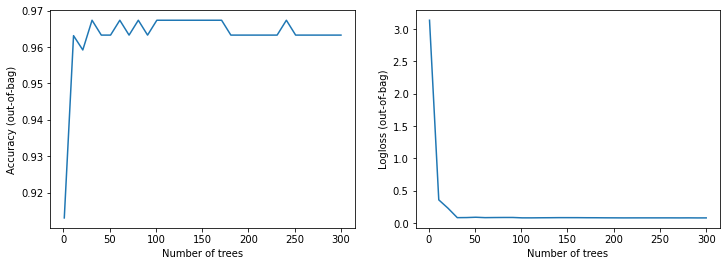

In [21]:
import matplotlib.pyplot as plt 

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

**Retrain the model with a different learning algorithm**



In [24]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [25]:
# help works anywhere.
help(tfdf.keras.RandomForestModel)

# ? only works in ipython or notebooks, it usually opens on a separate panel.
tfdf.keras.RandomForestModel?

Help on class RandomForestModel in module tensorflow_decision_forests.keras:

class RandomForestModel(tensorflow_decision_forests.keras.wrappers.RandomForestModel)
 |  RandomForestModel(*args, **kwargs)
 |  
 |  Random Forest learning algorithm.
 |  
 |  A Random Forest (https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)
 |  is a collection of deep CART decision trees trained independently and without
 |  pruning. Each tree is trained on a random subset of the original training 
 |  dataset (sampled with replacement).
 |  
 |  The algorithm is unique in that it is robust to overfitting, even in extreme
 |  cases e.g. when there is more features than training examples.
 |  
 |  It is probably the most well-known of the Decision Forest training
 |  algorithms.
 |  
 |  Usage example:
 |  
 |  ```python
 |  import tensorflow_decision_forests as tfdf
 |  import pandas as pd
 |  
 |  dataset = pd.read_csv("project/dataset.csv")
 |  tf_dataset = tfdf.keras.pd_dataframe_to_tf_datase

**Using a subset of features- GradientBoostedTreesModel**

In the previous examples all features were taken into the model.
 Now we want to specify input features

In [27]:
feature1 = tfdf.keras.FeatureUsage(name="bill_length_mm")
feature2 = tfdf.keras.FeatureUsage(name="island")

all_features = [feature1, feature2]

#this model is trained using only 2 features to it will be worse
model_2 = tfdf.keras.GradientBoostedTreesModel(
    features=all_features, exclude_non_specified_features=True)

model_2.compile(metrics=["accuracy"])
model_2.fit(x=train_ds, validation_data=test_ds)

print(model_2.evaluate(test_ds, return_dict=True))

Use /tmp/tmprv_qfvit as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.275599
Training model
Model trained in 0:00:00.106835
Compiling model
1/1 [==============================] - 0s 80ms/step - loss: 0.0000e+00 - accuracy: 0.9495
{'loss': 0.0, 'accuracy': 0.9494949579238892}


TF-DF attaches a semantics to each feature, it controls how the feature is used by the model:

- Numerical- for quantities or counts with full ordering, e.g. age, the number of items 

- Categorical - type/class of in finite set of possible values without ordering
 
- Categorical-Set - a set of categorical values, can be string or integer 

We create a model that treats the year as a categorical feature.

In [29]:
feature_1 = tfdf.keras.FeatureUsage(name="year", semantic=tfdf.keras.FeatureSemantic.CATEGORICAL)
feature_2 = tfdf.keras.FeatureUsage(name="bill_length_mm")
feature_3 = tfdf.keras.FeatureUsage(name="sex")
all_features = [feature_1, feature_2, feature_3]

model_3 = tfdf.keras.GradientBoostedTreesModel(features=all_features, exclude_non_specified_features=True)
model_3.compile( metrics=["accuracy"])

with sys_pipes():
  model_3.fit(x=train_ds, validation_data= test_ds)

Use /tmp/tmpesv2ozk9 as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.363279
Training model
Model trained in 0:00:00.183195
Compiling model


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "GradientBoostedTreesGeneric" built
[INFO kernel.cc:1001] Use fast generic engine


1/1 [==============================] - 1s 971ms/step - val_loss: 0.0000e+00 - val_accuracy: 0.7273


**Hyper-parameters**

parameters that impact the quality of a final model

In [30]:
#a classical but slightly more complex model 
model_6 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500, growing_strategy="BEST_FIRST_GLOBAL", max_depth=8)
model_6.fit(x=train_ds)

Use /tmp/tmpdyrlrw6d as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.329910
Training model
Model trained in 0:00:07.049605
Compiling model
1/1 [==============================] - 8s 8s/step


In [31]:
#A more complex but possibly more accurate model 
model_6 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500, 
    growing_strategy="BEST_FIRST_GLOBAL", 
    max_depth=8,
    split_axis="SPARSE_OBLIQUE",
    categorical_algorithm="RANDOM")
model_6.fit(x=train_ds)

Use /tmp/tmpbgwrk8w9 as temporary training directory
Starting reading the dataset


1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.327665
Training model
Model trained in 0:00:06.294199
Compiling model
1/1 [==============================] - 7s 7s/step


In [32]:
#There are some templates of good hyper-parameters, e.g. banchamrk_rank1
model_8 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
model_8.fit(x=train_ds)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpn4f24o25 as temporary training directory
Starting reading the dataset


1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.133403
Training model
Model trained in 0:00:00.905804
Compiling model
1/1 [==============================] - 1s 1s/step


In [33]:
# the hyper-parameter templates for the Gradient Boosted Tree model
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())

[HyperParameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


**Feature Preprocessing**

We will pre-process the body_mass_g into body_mass-kg. 

In [34]:
%set_cell_height 300

body_mass_g = tf.keras.layers.Input(shape=(1,), name="body_mass_g")
body_mass_kg = body_mass_g / 1000.0

bill_length_mm = tf.keras.layers.Input(shape=(1,), name="bill_length_mm")

raw_inputs = {"body_mass_g": body_mass_g, "bill_length_mm": bill_length_mm}
processed_inputs = {"body_mass_kg": body_mass_kg, "bill_length_mm": bill_length_mm}

# "preprocessor" contains the preprocessing logic.
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

# "model_4" contains both the pre-processing logic and the decision forest.
model_4 = tfdf.keras.RandomForestModel(preprocessing=preprocessor)
model_4.fit(x=train_ds)

model_4.summary()

<IPython.core.display.Javascript object>

Use /tmp/tmp6hd9nqi0 as temporary training directory
Starting reading the dataset


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['island', 'bill_depth_mm', 'flipper_length_mm', 'sex', 'year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.519562
Training model
Model trained in 0:00:00.106494
Compiling model
1/1 [==============================] - 1s 679ms/step
Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          {'body_mass_kg': (None,   0         
                             1),                                 
                              'bill_length_mm': (None            
                             , 1)}                               
                                                                 
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (2):
	bill_length_mm
	body_mass_kg

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.        "__LABEL"  3

The same logic but with TensorFlow Feature Columns

In [36]:
def g_to_kg(x):
  return x / 1000

feature_columns = [
    tf.feature_column.numeric_column("body_mass_g", normalizer_fn=g_to_kg),
    tf.feature_column.numeric_column("bill_length_mm"),
]

preprocessing = tf.keras.layers.DenseFeatures(feature_columns)

model_5 = tfdf.keras.RandomForestModel(preprocessing=preprocessing)
model_5.compile(metrics=["accuracy"])
model_5.fit(x=train_ds)

Use /tmp/tmpu1acvlhr as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.214843
Training model
Model trained in 0:00:00.083415
Compiling model
1/1 [==============================] - 0s 339ms/step
